In [1]:
!pip install nltk

In [2]:
!pip install wordcloud

In [3]:
!pip install spacy

In [4]:
# Instalamos el modelo de idioma en español de spaCy
!python -m spacy download es_core_news_sm

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     --------------------------------------- 0.0/12.9 MB 435.7 kB/s eta 0:00:30
     ---------------------------------------- 0.1/12.9 MB 1.1 MB/s eta 0:00:12
      --------------------------------------- 0.3/12.9 MB 1.9 MB/s eta 0:00:07
     - -------------------------------------- 0.4/12.9 MB 2.0 MB/s eta 0:00:07
     - -------------------------------------- 0.4/12.9 MB 1.7 MB/s eta 0:00:08
     - -------------------------------------- 0.5/12.9 MB 1.9 MB/s eta 0:00:07
     - -------------------------------------- 0.6/12.9 MB 2.0 MB/s eta 0:00:07
     - -------------------------------------- 0.6/12.9 MB 2.0 MB/s eta 0:00:07
     -- ------------------------------------- 1.0/12.9 MB 2.3 MB/s eta 0:00:06
     --- ------------------------------------ 1.1/12.9 MB 2.4 MB/s eta 0:00:06
     --- ------------------------------------ 1.2/12.9 MB 2.4 MB/s eta 0:00:05
     ---- ----------------------------------- 1.3/12.9 MB 

In [33]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

In [6]:
# Leemos los dataframes
tweets = pd.read_csv('tweets_extraidos_preprocesados_sentimiento.csv',sep=',')

In [7]:
# Contar la cantidad de valores nulos en 'MiColumna'
cantidad_nulos_en_columna = tweets['Tweet Limpio'].isnull().sum()

# Imprimir la cantidad de valores nulos en 'MiColumna'
print("Cantidad de valores nulos en 'MiColumna':", cantidad_nulos_en_columna)

Cantidad de valores nulos en 'MiColumna': 2116


In [8]:
tweets.dropna(subset=['Tweet Limpio'], inplace=True)

In [10]:
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import time

# Descargar léxicos necesarios
nltk.download('vader_lexicon')

# Cargar el modelo de lenguaje en español de spaCy
nlp = spacy.load("es_core_news_sm")

# Crear una instancia del analizador de sentimientos VADER
sia = SentimentIntensityAnalyzer()

def preprocess_text(text):
    # Procesar el texto con spaCy
    doc = nlp(text)
    # Filtrar las palabras que no son stop words ni signos de puntuación
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    # Unir los tokens de nuevo en un texto
    preprocessed_text = " ".join(tokens)
    return preprocessed_text

# Función para aplicar el preprocesamiento en paralelo
def preprocess_parallel(column):
    with ThreadPoolExecutor(max_workers=4) as executor:
        result = list(tqdm(executor.map(preprocess_text, column), total=len(column), desc="Procesando"))
    return result

# Función para realizar el análisis de sentimientos
def analyze_sentiment(tweet):
    sentiment = sia.polarity_scores(tweet)
    if sentiment['compound'] >= 0.05:
        return 'Positivo'
    elif sentiment['compound'] <= -0.05:
        return 'Negativo'
    else:
        return 'Neutral'

# Función para aplicar el análisis de sentimientos en paralelo
def analyze_sentiment_parallel(column):
    with ThreadPoolExecutor(max_workers=4) as executor:
        result = list(tqdm(executor.map(analyze_sentiment, column), total=len(column), desc="Analizando Sentimientos"))
    return result

# Medir el tiempo de inicio
start_time = time.time()

# Aplicar el preprocesamiento a la columna "Tweet Limpio"
tweets['Tweet_Procesado_spaCy'] = preprocess_parallel(tweets['Tweet Limpio'])

# Aplicar el análisis de sentimientos a la columna "Tweet Procesado spaCy"
tweets['Sentimiento_VADER'] = analyze_sentiment_parallel(tweets['Tweet_Procesado_spaCy'])

# Medir el tiempo de finalización
end_time = time.time()

# Calcular el tiempo total de ejecución
total_time = end_time - start_time

# Guardar el DataFrame resultante con los sentimientos analizados
tweets.to_csv('tweets_con_sentimientos_VADER_SPACY.csv', index=False)

# Muestra el tiempo total de ejecución
print(f"Tiempo total de ejecución: {total_time} segundos")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Analizando Sentimientos: 100%|█████████████████████████████████████████████| 452277/452277 [00:00<00:00, 493219.74it/s]


Tiempo total de ejecución: 1428.6585791110992 segundos


In [12]:
tweets.head(2)

,ID,ID_Texto,Nombre BD,Nombre Usuario,Tweet Original,Emoticones,Tweet Preprocesado,Tweet Limpio,Analisis Sentimiento,Sentimiento Score,Idioma,Retweet Count,Favorite_count,Followers_count,Friends_count,Listed_count,Favourites_count,Statuses_count,Tweet_Procesado_spaCy,Sentimiento_VADER
0,110825732,110825732,Cantantes_Colombianos,Camilo,Gallo pinto en Costa Rica... y otras maneras d...,NaN,gallo pinto costa rica ... manera disfrutar vi...,gallo pinto costa rica manera disfrutar vida,POS,0.998737,es,177,4650,1735142,488,1442,3246,15649,gallo pinto costa rico disfrutar vida,Neutral
1,110825732,110825732,Cantantes_Colombianos,Camilo,"RT @rincondelatribu: La Tribu tiene casa, un h...",NaN,"rt @rincondelatribu : tribu casa , hogar , ⛺ \...",tribu casa hogar,POS,0.996282,es,44,0,1735142,488,1442,3246,15649,tribu casa hogar,Neutral


In [37]:
# Contar el número de tweets positivos
tweets_positivos = tweets[tweets['Sentimiento_VADER'] == 'Positivo']

# Calcular el porcentaje de tweets positivos
porcentaje_positivos = (len(tweets_positivos) / len(tweets)) * 100

print(f"Porcentaje de tweets positivos: {porcentaje_positivos:.2f}%")

Porcentaje de tweets positivos: 6.71%


In [38]:
# Contar el número de tweets negativos
tweets_negativos = tweets[tweets['Sentimiento_VADER'] == 'Negativo']

# Calcular el porcentaje de tweets negativos
porcentaje_negativos = (len(tweets_negativos) / len(tweets)) * 100

print(f"Porcentaje de tweets negativos: {porcentaje_negativos:.2f}%")

Porcentaje de tweets negativos: 1.89%


In [39]:
# Contar el número de tweets neutrales
tweets_neutrales = tweets[tweets['Sentimiento_VADER'] == 'Neutral']

# Calcular el porcentaje de tweets negativos
porcentaje_neutrales = (len(tweets_neutrales) / len(tweets)) * 100

print(f"Porcentaje de tweets negativos: {porcentaje_neutrales:.2f}%")

Porcentaje de tweets negativos: 91.40%


In [16]:
# Tabla que muestra la frecuencia de cada sentimiento para cada valor único de nombre_bd
tabla = pd.crosstab(tweets['Nombre BD'], tweets['Sentimiento_VADER'])
print(tabla)

Sentimiento_VADER                    Negativo  Neutral  Positivo
Nombre BD                                                       
Cantantes_Colombianos                     603    36135      4436
Deportistas_Colombianos                   753    37212      4840
Empresas_Colombianas                      389    35381      5993
Famosos                                  1058    40938      4108
Futbol_Colombiano                         181    40473      1353
Instituciones_del_Estado_Colombiano       742    45635      1597
Medios_Informaticos                      1378    52122      2339
Periodistas                              1449    44408      2063
Politicos_Colombianos                    1544    42764      2081
Universidades_Colombianas                 456    38310      1536


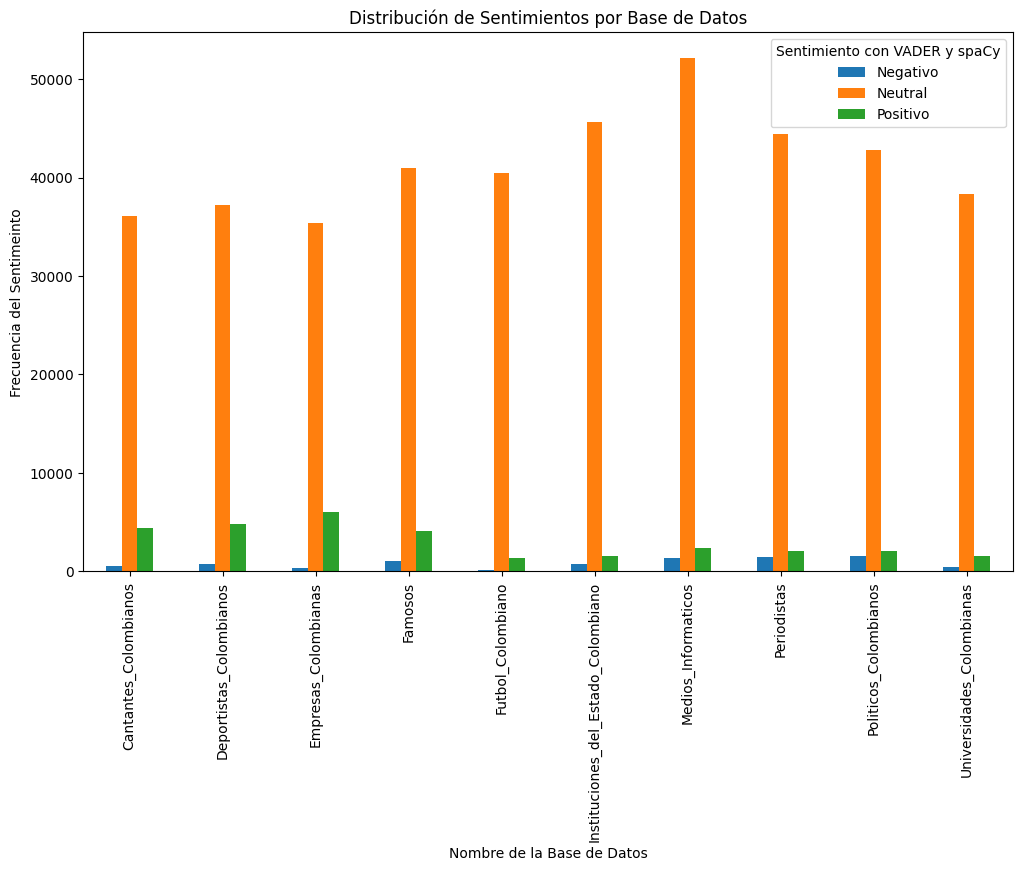

In [36]:
# Gráfico de barras agrupadas para visualizar la distribución
tabla.plot(kind='bar', figsize=(12, 7))
plt.title('Distribución de Sentimientos por Base de Datos')
plt.xlabel('Nombre de la Base de Datos')
plt.ylabel('Frecuencia del Sentimeinto')
plt.legend(title='Sentimiento con VADER y spaCy', loc='upper right')
plt.show()

In [18]:
# Nube de Palabras por cada Sentimiento
# Filtra los tweets por categoría de sentimiento
tweets_positivos = tweets[tweets['Sentimiento_VADER'] == 'Positivo']['Tweet_Procesado_spaCy'].tolist()
tweets_negativos = tweets[tweets['Sentimiento_VADER'] == 'Negativo']['Tweet_Procesado_spaCy'].tolist()
tweets_neutrales = tweets[tweets['Sentimiento_VADER'] == 'Neutral']['Tweet_Procesado_spaCy'].tolist()

In [19]:
# Muestra algunos ejemplos de tweets en cada categoría
print("Ejemplos de tweets positivos:")
print(tweets_positivos[:3])

print("Ejemplos de tweets negativos:")
print(tweets_negativos[:3])

print("Ejemplos de tweets neutrales:")
print(tweets_neutrales[:3])

Ejemplos de tweets positivos:
['maleta lleno carta   amor mate   amar argentino   ', 'comn jp gustar gente amar moderacin    moderacin jueves   ', 'increble partido argentinaaaaaaaa      fiesta     merecer venir    ']
Ejemplos de tweets negativos:
['querer hermano recordar conversacin jjajajo     feliz hayas paso     gracias po  ', 'im gonno leave this herir    feliz  ', 'escenario   cruzar mil millo paso   sentir cerca     fu  ']
Ejemplos de tweets neutrales:
['gallo pinto costa rico   disfrutar vida', '  tribu casa   hogar    ', 'contar    querer iiiiiiirrrrrr   ']


In [20]:
# Función para crear y mostrar nubes de palabras
def generar_y_mostrar_nube_de_palabras(texto, categoria):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texto))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Nube de Palabras - ' + categoria)
    plt.axis('off')
    plt.show()

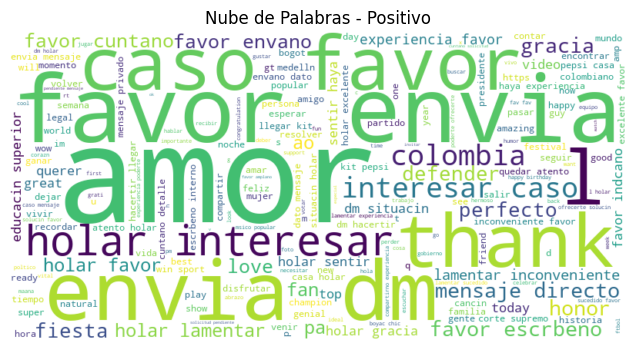

In [21]:
# Generar y mostrar nubes de palabras para Tweets Positivos
generar_y_mostrar_nube_de_palabras(tweets_positivos, "Positivo")

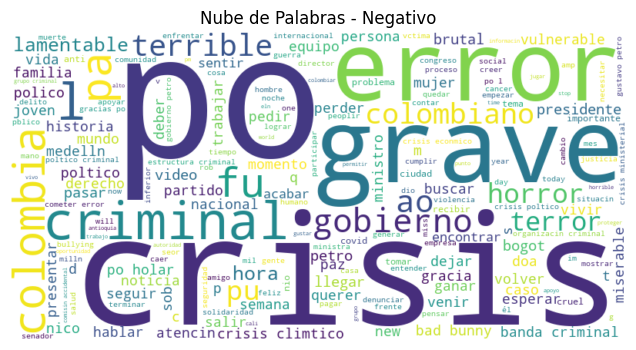

In [22]:
# Generar y mostrar nubes de palabras para Tweets Negativos
generar_y_mostrar_nube_de_palabras(tweets_negativos, "Negativo")

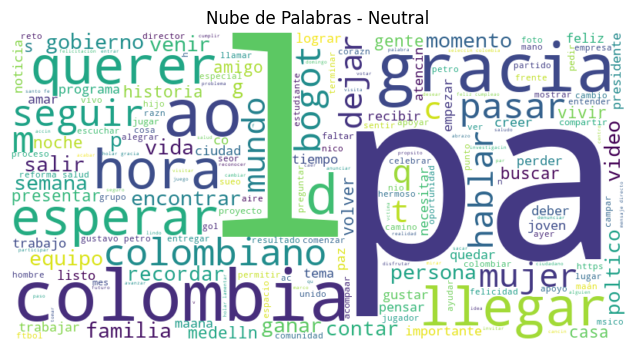

In [23]:
# Generar y mostrar nubes de palabras para Tweets Neutrales
generar_y_mostrar_nube_de_palabras(tweets_neutrales, "Neutral")

In [24]:
tweets.dropna(subset=['Tweet Limpio'], inplace=True)

In [25]:
etiquetas = tweets["Sentimiento_VADER"]
conteo_etiquetas = etiquetas.value_counts()
print(conteo_etiquetas)

Sentimiento_VADER
Neutral     413378
Positivo     30346
Negativo      8553
Name: count, dtype: int64


In [26]:
!pip install tabulate

In [27]:
from tabulate import tabulate
# Usar groupby para agrupar por la columna "Grupo" y luego sumar la columna "Valor"
result = tweets.groupby('Nombre BD')['Retweet Count'].sum().reset_index()
# Mostrar los resultados en una tabla
table1 = tabulate(result, headers='keys', tablefmt='pretty', showindex=False)

# Imprimir la tabla
print(table1)

+-------------------------------------+---------------+
|              Nombre BD              | Retweet Count |
+-------------------------------------+---------------+
|        Cantantes_Colombianos        |   13710909    |
|       Deportistas_Colombianos       |   18732322    |
|        Empresas_Colombianas         |    167205     |
|               Famosos               |   21745034    |
|          Futbol_Colombiano          |    1228366    |
| Instituciones_del_Estado_Colombiano |    3936526    |
|         Medios_Informaticos         |    587961     |
|             Periodistas             |   18904010    |
|        Politicos_Colombianos        |   26096428    |
|      Universidades_Colombianas      |    199409     |
+-------------------------------------+---------------+


In [28]:
# Tabla que muestra la frecuencia de cada sentimiento para cada valor único de nombre_bd
tabla = pd.crosstab(tweets['Nombre BD'], tweets['Sentimiento_VADER'])
print(tabla)

Sentimiento_VADER                    Negativo  Neutral  Positivo
Nombre BD                                                       
Cantantes_Colombianos                     603    36135      4436
Deportistas_Colombianos                   753    37212      4840
Empresas_Colombianas                      389    35381      5993
Famosos                                  1058    40938      4108
Futbol_Colombiano                         181    40473      1353
Instituciones_del_Estado_Colombiano       742    45635      1597
Medios_Informaticos                      1378    52122      2339
Periodistas                              1449    44408      2063
Politicos_Colombianos                    1544    42764      2081
Universidades_Colombianas                 456    38310      1536


In [29]:
# Calcular el promedio de 'Retweet Count' para cada combinación de "Nombre BD" y "Sentimiento"
promedio_retweets_por_polaridad_y_bd = tweets.pivot_table(values='Retweet Count', index='Nombre BD', columns='Sentimiento_VADER', aggfunc='mean')

# Imprimir el resultado
print(promedio_retweets_por_polaridad_y_bd)

Sentimiento_VADER                       Negativo     Neutral     Positivo
Nombre BD                                                                
Cantantes_Colombianos                 572.668325  298.142078   584.361136
Deportistas_Colombianos              1418.678619  411.422982   486.401860
Empresas_Colombianas                    2.071979    4.410757     1.725680
Famosos                              3412.014178  351.503664   911.700584
Futbol_Colombiano                      20.337017   29.039705    36.482631
Instituciones_del_Estado_Colombiano   146.055256   79.100975   136.743895
Medios_Informaticos                    15.248911   10.494110     8.539547
Periodistas                           938.151829  329.635404  1408.714978
Politicos_Colombianos                 861.076425  538.777734   829.714080
Universidades_Colombianas               6.901316    4.665335    11.414714


In [30]:
# Calcular el promedio de 'Retweet Count' para cada combinación de "Nombre BD" y "Sentimiento"
promedio_retweets_por_polaridad_y_bd = tweets.pivot_table(values='Retweet Count', index='Nombre BD', columns='Sentimiento_VADER', aggfunc='mean')

# Imprimir el resultado
print(promedio_retweets_por_polaridad_y_bd)

Sentimiento_VADER                       Negativo     Neutral     Positivo
Nombre BD                                                                
Cantantes_Colombianos                 572.668325  298.142078   584.361136
Deportistas_Colombianos              1418.678619  411.422982   486.401860
Empresas_Colombianas                    2.071979    4.410757     1.725680
Famosos                              3412.014178  351.503664   911.700584
Futbol_Colombiano                      20.337017   29.039705    36.482631
Instituciones_del_Estado_Colombiano   146.055256   79.100975   136.743895
Medios_Informaticos                    15.248911   10.494110     8.539547
Periodistas                           938.151829  329.635404  1408.714978
Politicos_Colombianos                 861.076425  538.777734   829.714080
Universidades_Colombianas               6.901316    4.665335    11.414714


In [31]:
# Calcular el promedio de 'Followers_count' para cada combinación de "Nombre BD" y "Sentimiento"
promedio_followers_count_por_polaridad_y_bd = tweets.pivot_table(values='Followers_count', index='Nombre BD', columns='Sentimiento_VADER', aggfunc='mean')

# Imprimir el resultado
print(promedio_followers_count_por_polaridad_y_bd)

Sentimiento_VADER                        Negativo       Neutral      Positivo
Nombre BD                                                                    
Cantantes_Colombianos                1.175658e+07  4.475521e+06  1.208751e+07
Deportistas_Colombianos              2.504504e+06  2.631846e+06  2.677545e+06
Empresas_Colombianas                 2.572225e+05  2.022982e+05  1.473550e+05
Famosos                              2.381936e+06  2.474210e+06  2.413959e+06
Futbol_Colombiano                    6.723069e+05  7.466000e+05  4.371256e+05
Instituciones_del_Estado_Colombiano  8.121040e+05  7.430910e+05  7.398319e+05
Medios_Informaticos                  3.588616e+06  3.390652e+06  3.028541e+06
Periodistas                          1.211512e+06  1.064318e+06  1.113350e+06
Politicos_Colombianos                1.582551e+06  1.623070e+06  1.765938e+06
Universidades_Colombianas            1.059536e+05  7.543297e+04  7.960331e+04


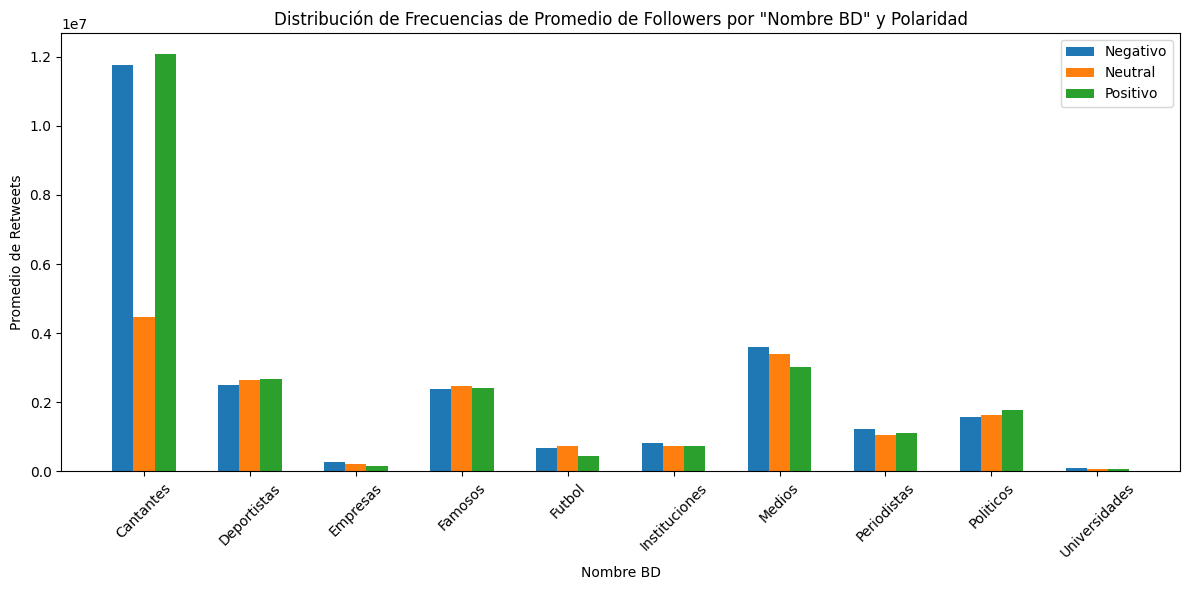

In [34]:
# Obtener las categorías de "Nombre BD" y las polaridades
categorias = promedio_followers_count_por_polaridad_y_bd.index
polaridades = promedio_followers_count_por_polaridad_y_bd.columns

nombres_base_datos = {
    'Cantantes_Colombianos': 'Cantantes',
    'Deportistas_Colombianos': 'Deportistas',
    'Empresas_Colombianas': 'Empresas',
    'Famosos': 'Famosos',
    'Futbol_Colombiano': 'Futbol',
    'Instituciones_del_Estado_Colombiano': 'Instituciones',
    'Medios_Informaticos': 'Medios',
    'Periodistas': 'Periodistas',
    'Politicos_Colombianos': 'Politicos',
    'Universidades_Colombianas': 'Universidades',
    # Agrega más nombres aquí si es necesario
}
# Configurar el ancho de las barras
ancho_barra = 0.2
indice = np.arange(len(categorias))

# Crear un gráfico de barras agrupadas
plt.figure(figsize=(12, 6))  # Ajustar el tamaño del gráfico

for i, polaridad in enumerate(polaridades):
    promedios = promedio_followers_count_por_polaridad_y_bd[polaridad]
    plt.bar(indice + i * ancho_barra, promedios, width=ancho_barra, label=polaridad)

plt.xlabel('Nombre BD')
plt.ylabel('Promedio de Retweets')
plt.title('Distribución de Frecuencias de Promedio de Followers por "Nombre BD" y Polaridad')
plt.legend()
# Reemplazar los nombres de bases de datos en el eje x utilizando el diccionario
nombres_reemplazados = [nombres_base_datos.get(cat, cat) for cat in categorias]
plt.xticks(indice + (len(polaridades) - 1) * ancho_barra / 2, nombres_reemplazados, rotation=45)
plt.tight_layout()
plt.show()

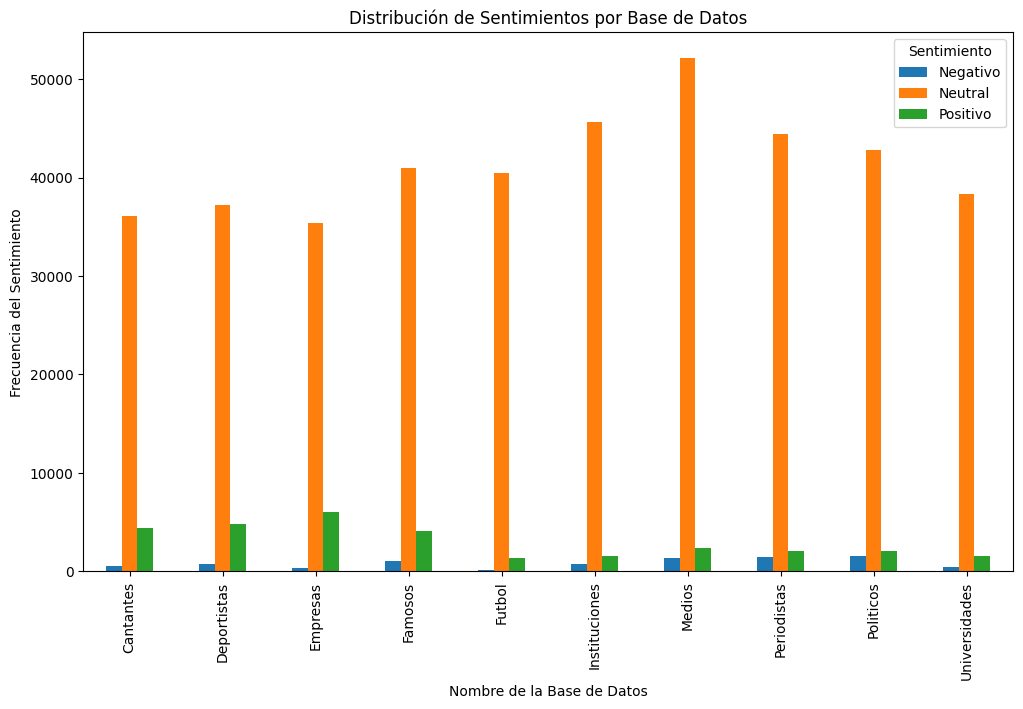

In [35]:
# Gráfico de barras agrupadas para visualizar la distribución
nombres_base_datos = {
    'Cantantes_Colombianos': 'Cantantes',
    'Deportistas_Colombianos': 'Deportistas',
    'Empresas_Colombianas': 'Empresas',
    'Famosos': 'Famosos',
    'Futbol_Colombiano': 'Futbol',
    'Instituciones_del_Estado_Colombiano': 'Instituciones',
    'Medios_Informaticos': 'Medios',
    'Periodistas': 'Periodistas',
    'Politicos_Colombianos': 'Politicos',
    'Universidades_Colombianas': 'Universidades',
    # Agrega más nombres aquí si es necesario
}

# Crea el gráfico de barras agrupadas
ax = tabla.plot(kind='bar', figsize=(12, 7))

# Obtiene las etiquetas actuales en el eje x
etiquetas_actuales = [tick.get_text() for tick in ax.get_xticklabels()]

# Crea una lista de etiquetas renombradas usando el diccionario
etiquetas_renombradas = [nombres_base_datos.get(etiqueta, etiqueta) for etiqueta in etiquetas_actuales]

# Establece las etiquetas renombradas en el eje x
ax.set_xticklabels(etiquetas_renombradas)

# Personaliza otros aspectos del gráfico
plt.title('Distribución de Sentimientos por Base de Datos')
plt.xlabel('Nombre de la Base de Datos')
plt.ylabel('Frecuencia del Sentimiento')
plt.legend(title='Sentimiento', loc='upper right')
plt.show()

In [40]:
etiquetas = tweets["Analisis Sentimiento"]
conteo_etiquetas = etiquetas.value_counts()
print(conteo_etiquetas)

Analisis Sentimiento
NEU    297665
POS     92364
NEG     62248
Name: count, dtype: int64


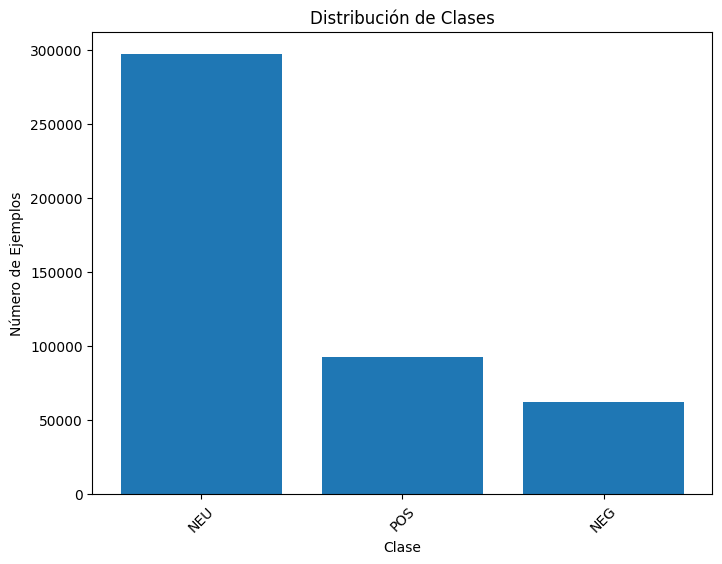

In [41]:
# Visualiza la distribución de clases
plt.figure(figsize=(8, 6))
plt.bar(conteo_etiquetas.index, conteo_etiquetas.values)
plt.xlabel('Clase')
plt.ylabel('Número de Ejemplos')
plt.title('Distribución de Clases')
plt.xticks(rotation=45)  # Opcional: gira las etiquetas en el eje x si son largas
plt.show()